# Working with EMIT L2A reflectance

In [1]:
# import the required packages
import os, sys, math
import earthaccess
import folium
import pyproj
import geopandas as gpd
import pandas as pd
import rasterio as rio
import rioxarray as rxr
import xarray as xr
import holoviews as hv
import hvplot.xarray
import netCDF4 as nc
import numpy as np

from shapely.geometry import box

os.environ['PROJ_LIB'] = pyproj.datadir.get_data_dir()

# This will ignore some warnings caused by holoviews
import warnings
warnings.simplefilter('ignore')

# load the EMIT tools (NASA)
sys.path.append('../tools/emit/python/modules/')
from emit_tools import emit_xarray, ortho_xr

auth = earthaccess.login()
earthaccess.login(persist=True)

print("Ready to go !")

Ready to go !


In [2]:
# Make a map of the area of interest using folium
# Add a lat/lon (ex/ Red Shirt)
lat, lon = 43.67318290826947, -102.90220519847095
# Create the folium map centered at the location
m = folium.Map(location=[lat, lon],
               zoom_start=14,
               tiles="Esri.WorldImagery")  # aerial basemap
# Add a marker for the location
folium.Marker(
    location=[lat, lon],
    popup="OLC"
).add_to(m)
m

### Search for EMIT L2A surface reflectance granules using NASA's earthaccess package

In [3]:
# create a bounding box 1km around our lat/lon
# X km buffer in degrees
buffer_km = 5
buffer_deg = buffer_km / 111.0 # to degrees

# Bounding box (west, south, east, north)
bounding_box = (
    lon - buffer_deg,  # west
    lat - buffer_deg,  # south
    lon + buffer_deg,  # east
    lat + buffer_deg   # north
)

print("Bounding box:", bounding_box)

# make a geodataframe
bbox_poly = box(*bounding_box)  # order is (minx, miny, maxx, maxy)
# Wrap in a GeoDataFrame
bbox_poly = gpd.GeoDataFrame(
    {"id": [1]},
    geometry=[bbox_poly],
    crs="EPSG:4326"
)

Bounding box: (-102.947250243516, 43.628137863224424, -102.85716015342591, 43.71822795331451)


In [4]:
# Retrieve Collections
collections = earthaccess.search_datasets(keyword='EMIT')
print(f'Collections found: {len(collections)}')

# Print Quantity of Results
collections_info = [
    {
        'short_name': c.summary()['short-name'],
        'collection_concept_id': c.summary()['concept-id'],
        'version': c.summary()['version'],
        'entry_title': c['umm']['EntryTitle']
    }
    for c in collections
]
pd.set_option('display.max_colwidth', 150)
collections_info = pd.DataFrame(collections_info)
collections_info

Collections found: 17


,short_name,collection_concept_id,version,entry_title
0,EMITL2ARFL,C2408750690-LPCLOUD,001,EMIT L2A Estimated Surface Reflectance and Uncertainty and Masks 60 m V001
1,EMITL1BRAD,C2408009906-LPCLOUD,001,EMIT L1B At-Sensor Calibrated Radiance and Geolocation Data 60 m V001
2,EMITL2BCH4ENH,C3242680113-LPCLOUD,002,EMIT L2B Methane Enhancement Data 60 m V002
3,EMITL2BCH4PLM,C2748088093-LPCLOUD,001,EMIT L2B Estimated Methane Plume Complexes 60 m V001
4,EMITL2BMIN,C2408034484-LPCLOUD,001,EMIT L2B Estimated Mineral Identification and Band Depth and Uncertainty 60 m V001
5,EMITL2BCH4ENH,C2748097305-LPCLOUD,001,EMIT L2B Methane Enhancement Data 60 m V001
6,EMITL2BCO2ENH,C3243477145-LPCLOUD,002,EMIT L2B Carbon Dioxide Enhancement Data 60 m V002
7,EMITL2BCO2ENH,C2872578364-LPCLOUD,001,EMIT L2B Carbon Dioxide Enhancement Data 60 m V001
8,EMITL2BCO2PLM,C2867824144-LPCLOUD,001,EMIT L2B Estimated Carbon Dioxide Plume Complexes 60 m V001
9,EMITL4ESM,C2408755900-LPCLOUD,001,EMIT L4 Earth System Model Products V001


In [5]:
# Search for EMIT L2A reflectance granules in our area of interest
first_date = "2025-06-01"
last_date = "2025-09-06"
granules = earthaccess.search_data(
    short_name="EMITL2ARFL",
    bounding_box=bounding_box,
    temporal=(first_date, last_date),
    cloud_hosted=True
)
# check how many granules were found
print(f"Found {len(granules)} granules between {first_date} and {last_date}")

Found 5 granules between 2025-06-01 and 2025-09-06


In [6]:
# print one granule to see what the structure looks like
print(granules[0])

Collection: {'ShortName': 'EMITL2ARFL', 'Version': '001'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -103.30289459228516, 'Latitude': 44.078556060791016}, {'Longitude': -103.64130401611328, 'Latitude': 43.3621711730957}, {'Longitude': -102.6629867553711, 'Latitude': 42.9000358581543}, {'Longitude': -102.32457733154297, 'Latitude': 43.61642074584961}, {'Longitude': -103.30289459228516, 'Latitude': 44.078556060791016}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2025-06-08T21:41:34Z', 'EndingDateTime': '2025-06-08T21:41:46Z'}}
Size(MB): 3580.356647491455
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20250608T214134_2515914_022/EMIT_L2A_RFL_001_20250608T214134_2515914_022.nc', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20250608T214134_2515914_022/EMIT_L2A_RFLUNCERT_001_20250608T214134_2515914

In [7]:
# get the list of URLs (reflectance and QA bands)
emit_urls = [granule.data_links(access="external") for granule in granules]
# flatten out the list of URLs (reflectance and QA bands)
url_list = [url for urls in emit_urls for url in urls]
# get the reflectance url:
emit_rfl = url_list[0]
print(emit_rfl)
# and the quality assurance (QA) band:
emit_qa = url_list[2]
print(emit_qa)

https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20250608T214134_2515914_022/EMIT_L2A_RFL_001_20250608T214134_2515914_022.nc
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20250608T214134_2515914_022/EMIT_L2A_MASK_001_20250608T214134_2515914_022.nc


In [8]:
# Stream the EMIT granule
# Get HTTPS Session using Earthdata Login Info
fs = earthaccess.get_fsspec_https_session()

# Use the session (i.e., fs) to connect to the file
# this is basically giving us the file paths to stream the data
emit_fp = fs.open(emit_rfl)
emit_qa_fp = fs.open(emit_qa)

# Load the data with emit_tools (NASA module)
emit_ds = emit_xarray(emit_fp, ortho=False).load()
emit_ds = ortho_xr(emit_ds) # orthorectify the image with emit_tools
emit_ds

<xarray.Dataset> Size: 5GB
Dimensions:           (latitude: 1943, longitude: 2429, wavelengths: 285)
Coordinates:
  * wavelengths       (wavelengths) float32 1kB 380.9 388.3 ... 2.493e+03
    fwhm              (wavelengths) float32 1kB 8.415 8.415 ... 8.807 8.809
    good_wavelengths  (wavelengths) float32 1kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
  * latitude          (latitude) float64 16kB 44.02 44.02 44.02 ... 42.96 42.96
  * longitude         (longitude) float64 19kB -103.6 -103.6 ... -102.3 -102.3
    elev              (latitude, longitude) float32 19MB nan nan nan ... nan nan
    spatial_ref       int64 8B 0
Data variables:
    reflectance       (latitude, longitude, wavelengths) float32 5GB nan ... nan
Attributes: (12/39)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    spatialResolution:                 0.000542232520256367
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [-1.03642058e+02  5.42232520e-04 -0.00...
    day_night_flag:                    Day
    title:                             EMIT L2A Estimated Surface Reflectance...
    granule_id:                        EMIT_L2A_RFL_001_20250608T214134_25159...

In [9]:
# Crop the granule to a smaller region
# Define bounding box (same as before, WGS84 coords)
west, south, east, north = bounding_box

# Crop using rioxarray
emit_crop = emit_ds.rio.clip_box(
    minx=west, miny=south,
    maxx=east, maxy=north
)

In [10]:
# Number of spectral bands
n_bands = emit_crop.sizes["wavelengths"]
print(f"Number of spectral bands: {n_bands}")

# Range of wavelengths
wvl = emit_crop["wavelengths"].values
print(f"Wavelength range: {wvl.min():.1f}–{wvl.max():.1f} nm")

Number of spectral bands: 285
Wavelength range: 380.9–2492.8 nm


In [11]:
# clean up some of the bad reflectance data
emit_crop['reflectance'].data[:,:,emit_crop['good_wavelengths'].data==0] = np.nan
emit_crop['reflectance'].data[emit_crop['reflectance'].data == -9999] = np.nan

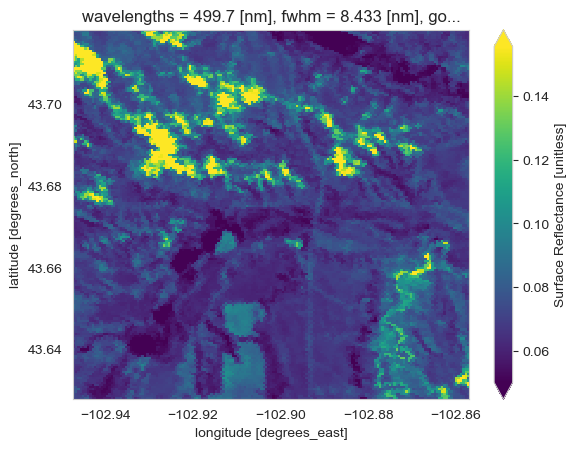

In [14]:
# Plot one band (red-edge ish, somewhere in the near-infrared region)
emit_crop['reflectance'].sel(wavelengths=500, method="nearest").plot(
    cmap="viridis", robust=True
)

In [15]:
# interactively plot the image
emit_layer = emit_crop.sel(wavelengths=850,method='nearest')
emit_layer.hvplot.image(
    cmap='viridis',
    geo=True,
    tiles='ESRI',
    crs='EPSG:4326',
    frame_width=620,
    frame_height=405,
    alpha=0.7,
    fontscale=2
).opts(
    title=f"{emit_layer.wavelengths:.3f} {emit_layer.wavelengths.units}",
    xlabel='Longitude',
    ylabel='Latitude'
)

:Overlay
   .WMTS.I  :WMTS   [Longitude,Latitude]
   .Image.I :Image   [longitude,latitude]   (Surface Reflectance)

In [16]:
# plot RGB

# define a helper function to adjust (stretch) color values
# this is necessary so the image is not just a dark blob
# function from:
def gamma_adjust(rgb_ds, bright=0.3, white_background=False):
    array = rgb_ds.reflectance.data
    gamma = math.log(bright)/math.log(np.nanmean(array)) # Create exponent for gamma scaling - can be adjusted by changing 0.2
    scaled = np.power(array,gamma).clip(0,1) # Apply scaling and clip to 0-1 range
    if white_background == True:
        scaled = np.nan_to_num(scaled, nan = 1) # Assign NA's to 1 so they appear white in plots
    rgb_ds.reflectance.data = scaled
    return rgb_ds

rgb = emit_crop.sel(wavelengths=[650, 560, 470], method='nearest')
rgb = gamma_adjust(rgb, white_background=True) # gamma adjust for plotting

# plot it
map = rgb.hvplot.rgb(x='longitude', y='latitude', bands='wavelengths', aspect = 'equal', frame_height=500)
map

:RGB   [longitude,latitude]   (R,G,B)

In [17]:
# https://github.com/nasa/EMIT-Data-Resources/blob/main/python/tutorials/Exploring_EMIT_L2A_Reflectance.ipynb
# Set Point Limit
POINT_LIMIT = 10

# Set up  Color Cycling
color_cycle = hv.Cycle('Category20')
colors = [color_cycle[i] for i in range(5)]

# Get center coordinates of image
xmid = emit_crop.longitude.values[int(len(emit_crop.longitude) / 2)]
ymid = emit_crop.latitude.values[int(len(emit_crop.latitude) / 2)]

#
first_point = ([xmid], [ymid], [0])
points = hv.Points(first_point, vdims='id')
points_stream = hv.streams.PointDraw(
    data=points.columns(),
    source=points,
    drag=True,
    num_objects=POINT_LIMIT,
    styles={'fill_color': color_cycle.values[1:POINT_LIMIT+1], 'line_color': 'gray'}
)

posxy = hv.streams.PointerXY(source=map, x=xmid, y=ymid)
clickxy = hv.streams.Tap(source=map, x=xmid, y=ymid)

# Function to build spectral plot of clicked location to show on hover stream plot
def click_spectra(data):
    coordinates = []
    if data is None or not any(len(d) for d in data.values()):
        coordinates.append(clicked_points[0][0], clicked_points[1][0])
    else:
        coordinates = [c for c in zip(data['x'], data['y'])]

    plots = []
    for i, coords in enumerate(coordinates):
        x, y = coords
        data = emit_crop.sel(longitude=x, latitude=y, method="nearest")
        plots.append(
            data.hvplot.line(
                y="reflectance",
                x="wavelengths",
                color=color_cycle,
                label=f"{i}"
            )
        )
        points_stream.data["id"][i] = i
    return hv.Overlay(plots)

def hover_spectra(x,y):
    return emit_crop.sel(longitude=x,latitude=y,method='nearest').hvplot.line(y='reflectance',x='wavelengths',
                                                                           color='black', frame_width=400)
# Define the Dynamic Maps
click_dmap = hv.DynamicMap(click_spectra, streams=[points_stream])
hover_dmap = hv.DynamicMap(hover_spectra, streams=[posxy])

# Plot the Map and Dynamic Map side by side
hv.Layout(hover_dmap*click_dmap + map * points).cols(2).opts(
    hv.opts.Points(active_tools=['point_draw'], size=10, tools=['hover'], color='white', line_color='gray'),
    hv.opts.Overlay(show_legend=False, show_title=False, fontscale=1.5, frame_height=480)
)

:Layout
   .DynamicMap.I :DynamicMap   []
      :Overlay
         .Curve.I   :Curve   [wavelengths]   (Surface Reflectance)
         .Curve.A_0 :Curve   [wavelengths]   (Surface Reflectance)
   .Overlay.I    :Overlay
      .RGB.I    :RGB   [longitude,latitude]   (R,G,B)
      .Points.I :Points   [x,y]   (id)

### Harmonized Landsat/Sentinel Comparison

In [18]:
granules = earthaccess.search_data(
    short_name="HLSS30",  # Sentinel-2 in HLS
    bounding_box=bounding_box,
    temporal=(first_date, last_date),
    cloud_hosted=True
)
print(f"Found {len(granules)} HLS Sentinel-2 granules")

Found 43 HLS Sentinel-2 granules


In [19]:
g = granules[0]
print(g["umm"].keys())
print(g["umm"]["AdditionalAttributes"][:5])

dict_keys(['TemporalExtent', 'GranuleUR', 'AdditionalAttributes', 'SpatialExtent', 'ProviderDates', 'CollectionReference', 'RelatedUrls', 'DataGranule', 'Platforms', 'MetadataSpecification'])
[{'Name': 'PRODUCT_URI', 'Values': ['S2B_MSIL1C_20250601T173909_N0511_R098_T13TFJ_20250601T211503.SAFE']}, {'Name': 'CLOUD_COVERAGE', 'Values': ['7']}, {'Name': 'MGRS_TILE_ID', 'Values': ['13TFJ']}, {'Name': 'SPATIAL_COVERAGE', 'Values': ['99']}, {'Name': 'SPATIAL_RESOLUTION', 'Values': ['30.0']}]


In [20]:
def get_cloud_coverage(granule):
    """Extract CLOUD_COVERAGE from HLS Sentinel-2 granule metadata"""
    attrs = granule["umm"].get("AdditionalAttributes", [])
    for att in attrs:
        if att["Name"] == "CLOUD_COVERAGE":
            return float(att["Values"][0])
    return None

# Find the granule with the lowest cloud cover
best_granule = min(granules, key=lambda g: get_cloud_coverage(g) or 100)
print("Best granule:", best_granule["umm"]["GranuleUR"])
print("Cloud coverage:", get_cloud_coverage(best_granule), "%")
print("Date:", best_granule["umm"]["TemporalExtent"]["RangeDateTime"]["BeginningDateTime"])
pd.json_normalize(best_granule).columns

Best granule: HLS.S30.T13TFJ.2025152T175741.v2.0
Cloud coverage: 1.0 %
Date: 2025-06-01T18:02:09.252Z


Index(['size', 'meta.concept-type', 'meta.concept-id', 'meta.revision-id',
       'meta.native-id', 'meta.collection-concept-id', 'meta.provider-id',
       'meta.format', 'meta.revision-date',
       'umm.TemporalExtent.RangeDateTime.BeginningDateTime',
       'umm.TemporalExtent.RangeDateTime.EndingDateTime', 'umm.GranuleUR',
       'umm.AdditionalAttributes',
       'umm.SpatialExtent.HorizontalSpatialDomain.Geometry.GPolygons',
       'umm.ProviderDates', 'umm.CollectionReference.EntryTitle',
       'umm.RelatedUrls', 'umm.DataGranule.DayNightFlag',
       'umm.DataGranule.Identifiers', 'umm.DataGranule.ProductionDateTime',
       'umm.DataGranule.ArchiveAndDistributionInformation', 'umm.Platforms',
       'umm.MetadataSpecification.URL', 'umm.MetadataSpecification.Name',
       'umm.MetadataSpecification.Version'],
      dtype='object')

In [21]:
# get URLs for reflectance file
urls = best_granule.data_links(access="external")
print(urls)

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T13TFJ.2025152T175741.v2.0/HLS.S30.T13TFJ.2025152T175741.v2.0.B12.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T13TFJ.2025152T175741.v2.0/HLS.S30.T13TFJ.2025152T175741.v2.0.B01.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T13TFJ.2025152T175741.v2.0/HLS.S30.T13TFJ.2025152T175741.v2.0.B09.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T13TFJ.2025152T175741.v2.0/HLS.S30.T13TFJ.2025152T175741.v2.0.SAA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T13TFJ.2025152T175741.v2.0/HLS.S30.T13TFJ.2025152T175741.v2.0.B10.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T13TFJ.2025152T175741.v2.0/HLS.S30.T13TFJ.2025152T175741.v2.0.VZA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/H

In [22]:
# GDAL configurations used to successfully access LP DAAC Cloud Assets via vsicurl
from osgeo import gdal
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')
gdal.SetConfigOption('GDAL_HTTP_UNSAFESSL', 'YES')

In [23]:
# subset bands to calculate EVI
evi_band_links = []

# Define which HLS product is being accessed
if urls[0].split('/')[4] == 'HLSS30.020':
    evi_bands = ['B8A', 'B04', 'B02', 'Fmask'] # NIR RED BLUE Quality for S30
else:
    evi_bands = ['B05', 'B04', 'B02', 'Fmask'] # NIR RED BLUE Quality for L30

# Subset the assets in the item down to only the desired bands
for a in urls:
    if any(b in a for b in evi_bands):
        evi_band_links.append(a)
evi_band_links

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T13TFJ.2025152T175741.v2.0/HLS.S30.T13TFJ.2025152T175741.v2.0.B8A.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T13TFJ.2025152T175741.v2.0/HLS.S30.T13TFJ.2025152T175741.v2.0.B04.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T13TFJ.2025152T175741.v2.0/HLS.S30.T13TFJ.2025152T175741.v2.0.B02.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T13TFJ.2025152T175741.v2.0/HLS.S30.T13TFJ.2025152T175741.v2.0.Fmask.tif']

In [24]:
# Use vsicurl to load the data directly into memory (be patient, may take a few seconds)
import dask
chunk_size = dict(band=1, x=512, y=512) # Tiles have 1 band and are divided into 512x512 pixel chunks
bands = []
for e in evi_band_links:
    print(e)
    if e.rsplit('.', 2)[-2] == evi_bands[0]:      # NIR index
        nir = rxr.open_rasterio(e, chunks=chunk_size, masked=True).squeeze('band', drop=True)
        nir.attrs['scale_factor'] = 0.0001                         # hard coded the scale_factor attribute
    elif e.rsplit('.', 2)[-2] == evi_bands[1]:    # red index
        red = rxr.open_rasterio(e, chunks=chunk_size, masked=True).squeeze('band', drop=True)
        red.attrs['scale_factor'] = 0.0001                         # hard coded the scale_factor attribute
    elif e.rsplit('.', 2)[-2] == evi_bands[2]:    # blue index
        blue = rxr.open_rasterio(e, chunks=chunk_size, masked=True).squeeze('band', drop=True)
        blue.attrs['scale_factor'] = 0.0001                        # hard coded the scale_factor attribute
    # elif e.rsplit('.', 2)[-2] == evi_bands[3]:    # Fmask index
    #    fmask = rxr.open_rasterio(e, chunks=chunk_size, masked=True).astype('uint16').squeeze('band', drop=True)
print("The COGs have been loaded into memory!")

https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T13TFJ.2025152T175741.v2.0/HLS.S30.T13TFJ.2025152T175741.v2.0.B8A.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T13TFJ.2025152T175741.v2.0/HLS.S30.T13TFJ.2025152T175741.v2.0.B04.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T13TFJ.2025152T175741.v2.0/HLS.S30.T13TFJ.2025152T175741.v2.0.B02.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T13TFJ.2025152T175741.v2.0/HLS.S30.T13TFJ.2025152T175741.v2.0.Fmask.tif
The COGs have been loaded into memory!


In [25]:
nir

<xarray.DataArray (y: 3660, x: 3660)> Size: 54MB
dask.array<getitem, shape=(3660, 3660), dtype=float32, chunksize=(512, 512), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 29kB 6e+05 6e+05 6.001e+05 ... 7.098e+05 7.098e+05
  * y            (y) float64 29kB 4.9e+06 4.9e+06 4.9e+06 ... 4.79e+06 4.79e+06
    spatial_ref  int64 8B 0
Attributes: (12/41)
    ACCODE:                                            LaSRC v3.5.1.0
    add_offset:                                        0.0
    arop_ave_xshift(meters):                           0
    arop_ave_yshift(meters):                           0
    arop_ncp:                                          0
    arop_rmse(meters):                                 0
    ...                                                ...
    spatial_coverage:                                  48
    SPATIAL_RESOLUTION:                                30
    TILE_ID:                                           S2A_OPER_MSI_L1C_TL_2A...
    ULX:                                               600000
    ULY:                                               4900020
    AREA_OR_POINT:                                     Area

In [26]:
# crop to our bounding box
# reproject the region to the raster CRS
bbox = bbox_poly.to_crs(nir.spatial_ref.crs_wkt) # Take the CRS from the NIR tile that we opened and apply it to our field geodataframe.
# crop each of the bands
nir = nir.rio.clip(bbox.geometry.values, bbox.crs, all_touched=True) # All touched includes any pixels touched by the polygon
red = red.rio.clip(bbox.geometry.values, bbox.crs, all_touched=True)
blue = blue.rio.clip(bbox.geometry.values, bbox.crs, all_touched=True)

# plot the NIR band
nir.hvplot.image(aspect='equal', cmap='viridis', frame_height=500, frame_width= 500).opts(title='HLS Cropped NIR Band')  # Quick visual to assure that it worked

:Image   [x,y]   (NIR_Narrow)

In [29]:
# Define function to scale
def scaling(band):
    scale_factor = band.attrs['scale_factor']
    band_out = band.copy()
    band_out.data = band.data*scale_factor
    band_out.attrs['scale_factor'] = 1
    return(band_out)

# scale each band
nir_sc = scaling(nir)
red_sc = scaling(red)
blue_sc = scaling(blue)

In [28]:
def calc_evi(red, blue, nir):
    # Create EVI xarray.DataArray that has the same coordinates and metadata
    evi = red.copy()
    # Calculate the EVI
    evi_data = 2.5 * ((nir.data - red.data) / (nir.data + 6.0 * red.data - 7.5 * blue.data + 1.0))
    # Replace the Red xarray.DataArray data with the new EVI data
    evi.data = evi_data
    # exclude the inf values
    evi = xr.where(evi != np.inf, evi, np.nan, keep_attrs=True)
    # change the long_name in the attributes
    evi.attrs['long_name'] = 'EVI'
    evi.attrs['scale_factor'] = 1
    return evi

# make the EVI band
evi = calc_evi(red_sc, blue_sc, nir_sc) # Generate EVI array
evi.hvplot.image(
    aspect='equal',
    cmap='YlGn',
    frame_height=500,
    frame_width= 500
).opts(
    title=f'HLS-derived EVI, {evi.SENSING_TIME}',
    clabel='EVI')

:Image   [x,y]   (EVI)